In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from functools import partial

import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from boplay.acq_funs.mes_utils import sample_yn1_ymax
from boplay.kernels import se_kernel
from boplay.gp import GaussianProcess

import scienceplots
import seaborn as sns

# plt.style.use(['science','no-latex'])
plt.rcParams.update({"text.usetex": True})
plt.style.use(['science', 'grid', 'retro'])


In [3]:
np.random.seed(0)
import boplay

# the parent of the module
SAVE_DIR = Path(boplay.__file__).parent.parent / "paper_plots"
print(f"Pics will be saved to: {SAVE_DIR}")

Pics will be saved to: /lambda/nfs/nethome-us-west-1/lukehg/mes/paper_plots


# Generate Data to Plot

In [4]:


idx_train = np.array([0, 50, 90])

# Generate data to plot
n_yn1 = 41
n_ymax = 1000

# make a grid of x-values
x_grid = np.linspace(0, 100, 101).reshape(-1, 1)
n_x = x_grid.shape[0]

# make a train set of x-values and y-values
x_train = x_grid[idx_train, :]
y_train = np.asarray([0.5, 0.0, 1]).reshape(-1, 1)
y_best = float(max(y_train))

# make a kernel
kernel = partial(se_kernel, len_scale=10.0, sigma_f=1.0)

# make a Gaussian process
gp = GaussianProcess(x_train=x_train, y_train=y_train, kernel=kernel)

# get the mean and covariance of the Gaussian process
y_mean, y_cov = gp.predict(x_test=x_grid)

np.random.seed(0)
y_n1_samples, y_func_samples, y_max_samples, _ = sample_yn1_ymax(
    y_mean=y_mean,
    y_cov=y_cov,
    n_yn1=n_yn1,
    n_ymax=n_ymax,
    y_noise_std=0,
)




/tmp/ipykernel_1032387/3119468055.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_best = float(max(y_train))


# Subsample points to make the plot nice and readable

In [5]:
x_idx = 75
np.random.seed(4)

y_n1_samples_x_idx = y_n1_samples[x_idx, :, None]  # (n_yn1, 1)
y_n1_samples_x_idx = np.tile(y_n1_samples_x_idx, (1, n_ymax))  # (n_yn1, n_ymax)
y_max_samples_x_idx = y_max_samples[x_idx, :, :]  # (n_ymax, n_yn1)

# subsample the points to look a bit more random
y_n1_points = []
y_max_points = []
for i in range(n_yn1):
    plot_idx = np.random.choice(n_ymax, replace=False, size=4)
    y_n1_points.extend(list(y_n1_samples_x_idx[i, plot_idx]))
    y_max_points.extend(list(y_max_samples_x_idx[i, plot_idx]))

y_n1_points = np.array(y_n1_points)
y_max_points = np.array(y_max_points)

# save data for plotting elsewhere without resampling everything again
np.save(SAVE_DIR / "y_n1.npy", y_n1_points)
np.save(SAVE_DIR / "y_max.npy", y_max_points)


# Make Heatmap For Each Regression Model

In [6]:
# from boplay.acq_funs.regression_models import (
#     fit_lr_1_0,
#     fit_lr_1_1,
#     fit_lr_1_2,
#     fit_lr_2_0,
#     fit_lr_2_1,
#     fit_lr_2_2,
#     fit_gamma_0_0,
#     fit_gamma_0_1,
#     fit_gamma_0_2,
#     fit_exp_0,
#     fit_exp_1,
#     fit_exp_2,
# )

# # add a row dimension to the data
# x_data = y_n1_points[None, :]
# y_data = y_max_points[None, :]

# x_lim = (-2, 2.7)
# y_lim = ( 0.5, 4)

# y_n1_grid = np.linspace(x_lim[0], x_lim[1], 50)
# y_max_grid = np.linspace(y_lim[0], y_lim[1], 50)

# y_n1_grid_2d = np.tile(y_n1_grid, len(y_max_grid))
# y_max_grid_2d = np.repeat(y_max_grid, len(y_n1_grid))

# models = {
#     "lr_1_0": fit_lr_1_0,
#     "lr_1_1": fit_lr_1_1,
#     "lr_1_2": fit_lr_1_2,
#     "lr_2_0": fit_lr_2_0,
#     "lr_2_1": fit_lr_2_1,
#     "lr_2_2": fit_lr_2_2,
#     "gamma_0_0": fit_gamma_0_0,
#     "gamma_0_1": fit_gamma_0_1,
#     "gamma_0_2": fit_gamma_0_2,
#     "exp_0": fit_exp_0,
#     "exp_1": fit_exp_1,
#     "exp_2": fit_exp_2,
# }


# fig, axes = plt.subplots(4, 3, figsize=(10, 10))
# axes = axes.flatten()

# for i, (model_name, model_fun) in enumerate(models.items()):

#     make_heatmap_0_0 = model_fun(
#         x_data=x_data,
#         y_data=y_data,
#         x_min=y_best,
#         make_heatmap=True,
#     )

#     heatmap = make_heatmap_0_0(
#         row_idx=0,  # the heatmap for the 0th row of the initial data
#         x=y_n1_grid_2d,
#         y=y_max_grid_2d
#     )

#     heatmap = heatmap.reshape(len(y_max_grid), len(y_n1_grid))
#     heatmap = np.exp(heatmap)

#     ax = axes[i]
#     ax.set_title(model_name)
#     ax.imshow(heatmap, origin="lower", extent=x_lim + y_lim, cmap="viridis")
#     ax.scatter(y_n1_points, y_max_points, color="red", alpha=0.4)
#     ax.set_xlim(x_lim)
#     ax.set_ylim(y_lim)
#     ax.set_aspect("equal")
#     ax.set_xlabel("$y_{n+1}$")
#     ax.set_ylabel("$y^*$")


#### LHG heatmaps

In [7]:
# from boplay.acq_funs.regression_models import (
#     fit_lr_1_0,
#     fit_lr_1_1,
#     fit_lr_1_2,
#     fit_lr_2_0,
#     fit_lr_2_1,
#     fit_lr_2_2,
#     fit_gamma_0_0,
#     fit_gamma_0_1,
#     fit_gamma_0_2,
#     fit_exp_0,
#     fit_exp_1,
#     fit_exp_2,
# )



# # add a row dimension to the data
# x_data = y_n1_points[None, :]
# y_data = y_max_points[None, :]

# x_lim = (-2, 3)
# y_lim = ( 0.5, 4)

# y_n1_grid = np.linspace(x_lim[0], x_lim[1], 200)
# y_max_grid = np.linspace(y_lim[0], y_lim[1], 200)

# y_n1_grid_2d = np.tile(y_n1_grid, len(y_max_grid))
# y_max_grid_2d = np.repeat(y_max_grid, len(y_n1_grid))

# # models = {
# #     "lr_1_0": fit_lr_1_0,
# #     "lr_2_0": fit_lr_2_0,
# #     "gamma_0_0": fit_gamma_0_0,
# #     "exp_0": fit_exp_0,
# #     "lr_1_1": fit_lr_1_1,
# #     "lr_2_1": fit_lr_2_1,
# #     "gamma_0_1": fit_gamma_0_1,
# #     "exp_1": fit_exp_1,
# #     "lr_1_2": fit_lr_1_2,
# #     "lr_2_2": fit_lr_2_2,
# #     "gamma_0_2": fit_gamma_0_2,
# #     "exp_2": fit_exp_2,
# # }

# models = {
#     "lr_1_0": fit_lr_1_0,
#     "lr_1_1": fit_lr_1_1,
#     "lr_1_2": fit_lr_1_2,
#     "lr_2_0": fit_lr_2_0,
#     "lr_2_1": fit_lr_2_1,
#     "lr_2_2": fit_lr_2_2,
#     "gamma_0_0": fit_gamma_0_0,
#     "gamma_0_1": fit_gamma_0_1,
#     "gamma_0_2": fit_gamma_0_2,
#     "exp_0": fit_exp_0,
#     "exp_1": fit_exp_1,
#     "exp_2": fit_exp_2,
# }

# texts = {
#     "lr_1_0": [
#         r"$g_\theta(y_{n+1}) = my_{n+1} + c$",
#         r"$\epsilon \sim \mathcal{N}(0, 1)$",
#     ],
#     "lr_2_0": [
#         r"$g_\theta(y_{n+1}) = m\max(\bar y, y_{n+1}) + c$",
#         r"$\epsilon \sim \mathcal{N}(0, 1)$",
#     ],
# }

# COLUMNS = 3
# fig, axes = plt.subplots(len(models) // COLUMNS, COLUMNS, figsize=(13, 10), sharey=True, sharex=True)
# # fig, axes = plt.subplots(len(models) // COLUMNS, COLUMNS, figsize=(20, 7), sharey=True, sharex=True)
# axes = axes.flatten()
# # cmap = LinearSegmentedColormap.from_list("my_cmap", ["#FF6F79", "#B790BC", "#6FB0FF"])
# cmap = LinearSegmentedColormap.from_list("my_cmap", ["#FFFFFF", "#FF6F79"])


# for i, (model_name, model_fun) in enumerate(models.items()):

#     make_heatmap_0_0 = model_fun(
#         x_data=x_data,
#         y_data=y_data,
#         x_min=y_best,
#         make_heatmap=True,
#     )

#     heatmap = make_heatmap_0_0(
#         row_idx=0,  # the heatmap for the 0th row of the initial data
#         x=y_n1_grid_2d,
#         y=y_max_grid_2d
#     )


#     heatmap = heatmap.copy().reshape(len(y_max_grid), len(y_n1_grid))
#     heatmap = np.exp(heatmap)




#     ax = axes[i]
#     # ax.set_title(model_name)
#     local_texts = texts.get(model_name, [None, None])
#     if local_texts[0]:
#         t = ax.text(0.04, 0.85, local_texts[0], ha='left', va='bottom', transform=ax.transAxes, fontsize=15)
#         t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='none'))
#     if local_texts[1]:
#         ax.text(0.04, 0.7, local_texts[1], ha='left', va='bottom', transform=ax.transAxes, fontsize=15)
#     # ax.text(0.04, 0.9, model_name, ha='left', va='bottom', transform=ax.transAxes)

#     normed_heatmap = (heatmap - heatmap.min(axis=0)) / (heatmap.max(axis=0) - heatmap.min(axis=0))

#     im = ax.imshow(normed_heatmap, origin="lower", extent=x_lim + y_lim, cmap=cmap, vmin=0, vmax=1)

#     ax.tick_params(top=False, right=False)
#     ax.tick_params(which="minor", bottom=False, left=False)
#     ax.minorticks_off()
#     ax.scatter(y_n1_points, y_max_points, color="k", marker=".", s=30, alpha=0.8, edgecolors="none")
#     ax.set_xlim(x_lim)
#     ax.set_ylim(y_lim)
#     ax.tick_params(axis='both', which='major', labelsize=13)
#     if i // COLUMNS == len(models) // COLUMNS - 1:
#         ax.set_xticks([-2, -1, 0, 1, 2, 3])
#         ax.set_xlabel("$y_{n+1}$", fontsize=24)
#     if i % COLUMNS == 0:
#         ax.set_ylabel("$y^*$", rotation=0, fontsize=24, labelpad=20)
#         ax.set_yticks([1, 2, 3])
#     ax.set_ylim([0.5, 3.5])
#     ax.grid(False)
#     # sns.despine(ax=ax)
# plt.tight_layout()
# cbar = fig.colorbar(im, ax=axes, orientation='vertical', pad=0.02)
# cbar.ax.tick_params(labelsize=16)


# plt.savefig(SAVE_DIR / "models-test-grid-plot.pdf")

In [30]:
from boplay.acq_funs.regression_models import (
    fit_lr_1_0,
    fit_lr_1_1,
    fit_lr_1_2,
    fit_lr_2_0,
    fit_lr_2_1,
    fit_lr_2_2,
    fit_gamma_0_0,
    fit_gamma_0_1,
    fit_gamma_0_2,
    fit_exp_0,
    fit_exp_1,
    fit_exp_2,
)


models = {
    "gamma_0_0": fit_gamma_0_0,
    "exp_2": fit_exp_2,
    "lr_1_0": fit_lr_1_0,
    "lr_2_2": fit_lr_2_2,
}

models = {
    "lr_1_0": fit_lr_1_0,
    "lr_1_1": fit_lr_1_1,
    "lr_1_2": fit_lr_1_2,
}


def plot_trend_lines(models, filename, figsize):

    # add a row dimension to the data
    x_data = y_n1_points[None, :]
    y_data = y_max_points[None, :]

    x_lim = (-2, 3)
    y_lim = (-1, 3.5)

    y_n1_grid = np.linspace(x_lim[0], x_lim[1], 200)
    y_max_grid = np.linspace(y_lim[0], y_lim[1], 200)

    y_n1_grid_2d = np.tile(y_n1_grid, len(y_max_grid))
    y_max_grid_2d = np.repeat(y_max_grid, len(y_n1_grid))


    texts = {
        "lr_1_0": [
            r"$g(y_{n+1}) = L(y_{n+1})$",
            # r"$g_\theta(y_{n+1}) = m_gy_{n+1} + c_g$",
            r"$\epsilon \sim \mathcal{N}(0, C(y_{n+1}))$",
            # r"$\epsilon \sim \mathcal{N}(0, c_\epsilon)$",
        ],
        "lr_1_1": [
            r"$g(y_{n+1}) = L(y_{n+1})$",
            # r"$g_\theta(y_{n+1}) = m_gy_{n+1} + c_g$",
            r"$\epsilon \sim \mathcal{N}(0, L(y_{n+1}))$",
            # r"$\epsilon \sim \mathcal{N}(0, m_\epsilon y_{n+1} + c_\epsilon)$",
        ],
        "lr_1_2": [
            r"$g(y_{n+1}) = L(y_{n+1})$",
            # r"$g_\theta(y_{n+1}) = m_gy_{n+1} + c_g$",
            r"$\epsilon \sim \mathcal{N}(0, R(y_{n+1}))$",
            # r"$\epsilon \sim \mathcal{N}(0, m_\epsilon\max(\bar y, y_{n+1}) + c_\epsilon)$",
        ],
        "lr_2_0": [
            r"$g(y_{n+1}) = R(y_{n+1})$",
            # r"$g_\theta(y_{n+1}) = m_g\max(\bar y, y_{n+1}) + c_g$",
            r"$\epsilon \sim \mathcal{N}(0, C(y_{n+1}))$",
            # r"$\epsilon \sim \mathcal{N}(0, c_\epsilon)$",
        ],
        "lr_2_1": [
            r"$g(y_{n+1}) = R(y_{n+1})$",
            # r"$g_\theta(y_{n+1}) = m_g\max(\bar y, y_{n+1}) + c_g$",
            r"$\epsilon \sim \mathcal{N}(0, L(y_{n+1}))$",
            # r"$\epsilon \sim \mathcal{N}(0, m_\epsilon y_{n+1} + c_\epsilon)$",
        ],
        "lr_2_2": [
            r"$g(y_{n+1}) = R(y_{n+1})$",
            # r"$g_\theta(y_{n+1}) = m_g\max(\bar y, y_{n+1}) + c_g$",
            r"$\epsilon \sim \mathcal{N}(0, R(y_{n+1}))$",
            # r"$\epsilon \sim \mathcal{N}(0, m_\epsilon\max(\bar y, y_{n+1}) + c_\epsilon)$",
        ],
        "gamma_0_0": [
            r"$g_\theta(y_{n+1}) = \max(\bar y, y_{n+1})$",
            r"$\epsilon \sim \Gamma(k, C(y_{n+1}))$",
            # r"$\epsilon \sim \mathrm{Gamma}(k, c_\epsilon)$",
        ],
        "gamma_0_1": [
            r"$g_\theta(y_{n+1}) = \max(\bar y, y_{n+1})$",
            r"$\epsilon \sim \Gamma(k, L(y_{n+1}))$",
            # r"$\epsilon \sim \mathrm{Gamma}(k, m_\epsilon y_{n+1} + c_\epsilon)$",
        ],
        "gamma_0_2": [
            r"$g_\theta(y_{n+1}) = \max(\bar y, y_{n+1})$",
            r"$\epsilon \sim \Gamma(k, R(y_{n+1}))$",
            # r"$\epsilon \sim \mathrm{Gamma}(k, m_\epsilon\max(\bar y, y_{n+1}) + c_\epsilon)$",
        ],

        "exp_0": [
            r"$g_\theta(y_{n+1}) = \max(\bar y, y_{n+1})$",
            r"$\epsilon \sim \mathrm{Exp}(C(y_{n+1}))$",
            # r"$\epsilon \sim \mathrm{Exp}(c_\epsilon)$",
        ],
        "exp_1": [
            r"$g_\theta(y_{n+1}) = \max(\bar y, y_{n+1})$",
            r"$\epsilon \sim \mathrm{Exp}(L(y_{n+1}))$",
            # r"$\epsilon \sim \mathrm{Exp}(m_\epsilon y_{n+1} + c_\epsilon)$",
        ],
        "exp_2": [
            r"$g_\theta(y_{n+1}) = \max(\bar y, y_{n+1})$",
            r"$\epsilon \sim \mathrm{Exp}(R(y_{n+1}))$",
            # r"$\epsilon \sim \mathrm{Exp}(m_\epsilon\max(\bar y, y_{n+1}) + c_\epsilon)$",
        ],
    }

    COLUMNS = len(models)
    fig, axes = plt.subplots(len(models) // COLUMNS, COLUMNS, figsize=figsize, sharey=True, sharex=True)
    # fig, axes = plt.subplots(len(models) // COLUMNS, COLUMNS, figsize=(20, 7), sharey=True, sharex=True)
    axes = axes.flatten()
    # cmap = LinearSegmentedColormap.from_list("my_cmap", ["#FF6F79", "#B790BC", "#6FB0FF"])
    cmap = LinearSegmentedColormap.from_list("my_cmap", ["#FFFFFF", "#FF6F79"])


    for i, (model_name, model_fun) in enumerate(models.items()):

        make_heatmap_0_0 = model_fun(
            x_data=x_data,
            y_data=y_data,
            x_min=y_best,
            make_heatmap=True,
        )

        heatmap, params = make_heatmap_0_0(
            row_idx=0,  # the heatmap for the 0th row of the initial data
            x=y_n1_grid_2d,
            y=y_max_grid_2d
        )


        m_trend = params[:, 0].detach().cpu().numpy()[0]
        c_trend = params[:, 1].detach().cpu().numpy()[0]
        m_stdev = params[:, 2].detach().cpu().numpy()[0]
        c_stdev = params[:, 3].detach().cpu().numpy()[0]

        if model_name.startswith("gamma") or model_name.startswith("exp"):
            trend_line = np.maximum(y_n1_grid, y_best)
        elif model_name.startswith("lr_1"):
            trend_line = m_trend * y_n1_grid + c_trend
        elif model_name.startswith("lr_2"):
            trend_line = m_trend * np.maximum(y_n1_grid, y_best) + c_trend

        # trend_line = m_trend * y_n1_grid + c_trend
        # print(m_trend, c_trend)


        heatmap = heatmap.copy().reshape(len(y_max_grid), len(y_n1_grid))
        heatmap = np.exp(heatmap)


        ax = axes[i]
        # ax.set_title(model_name)
        local_texts = texts.get(model_name, [None, None])
        if local_texts[0]:
            t = ax.text(0.96, 0.19, local_texts[0], ha='right', va='bottom', transform=ax.transAxes, fontsize=12)
            # t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='none'))
        if local_texts[1]:
            ax.text(0.96, 0.045, local_texts[1], ha='right', va='bottom', transform=ax.transAxes, fontsize=12)
        # ax.text(0.04, 0.9, model_name, ha='left', va='bottom', transform=ax.transAxes)

        # normed_heatmap = (heatmap - heatmap.min(axis=0)) / (heatmap.max(axis=0) - heatmap.min(axis=0))

        col_min = heatmap.min(axis=0)
        col_rng = np.ptp(heatmap, axis=0) 

        normed_heatmap = np.divide(
            heatmap - col_min,
            col_rng,
            out=np.zeros_like(heatmap),
            where=col_rng != 0
        )


        im = ax.imshow(normed_heatmap, origin="lower", extent=x_lim + y_lim, cmap=cmap, vmin=0, vmax=1, aspect="auto")

        ax.plot(
            y_n1_grid,
            trend_line,
            linestyle="--", 
            color="k",
        )

        ax.tick_params(top=False, right=False, bottom=False, left=False )
        ax.tick_params(which="minor", bottom=False, left=False)
        ax.minorticks_off()
        ax.scatter(y_n1_points, y_max_points, color="#76A4EA", marker=".", s=30, alpha=0.8, edgecolors="none")
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.tick_params(axis='both', which='major', labelsize=13)
        if i // COLUMNS == len(models) // COLUMNS - 1:
            ax.set_xticks([-2, -1, 0, 1, 2, 3])
            ax.set_xlabel("$y_{n+1}$", fontsize=24)
        if i % COLUMNS == 0:
            ax.set_ylabel("$y^*$", rotation=0, fontsize=24, labelpad=13)
            ax.set_yticks([-1, 0, 1, 2, 3])
        # ax.set_ylim([0.5, 3.5])
        ax.grid(False)
        # sns.despine(ax=ax)
    plt.tight_layout()
    cbar = fig.colorbar(im, ax=axes, orientation='vertical', pad=0.02)
    cbar.ax.tick_params(labelsize=16)


    # plt.savefig(SAVE_DIR / "heatmaps-appendix-3.pdf")
    plt.savefig(SAVE_DIR / f"{filename}.pdf")
    # plt.cla()
    # plt.savefig(SAVE_DIR / "models-test-grid-plot-main-body.pdf")

/lambda/nfs/nethome-us-west-1/lukehg/mes/boplay/acq_funs/regression_models/lr_het_base.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_trend = pt.tensor(y_trend, **pt_params)
/lambda/nfs/nethome-us-west-1/lukehg/mes/boplay/acq_funs/regression_models/lr_het_base.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_log_sdev = pt.tensor(noise_log_sdev, **pt_params)


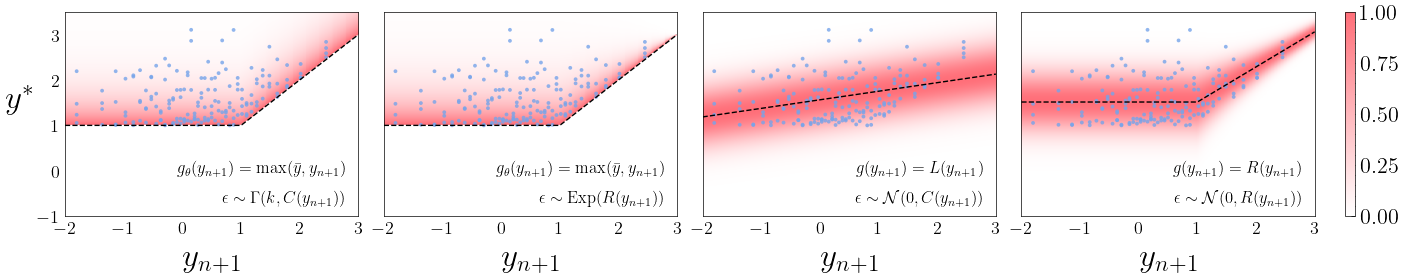

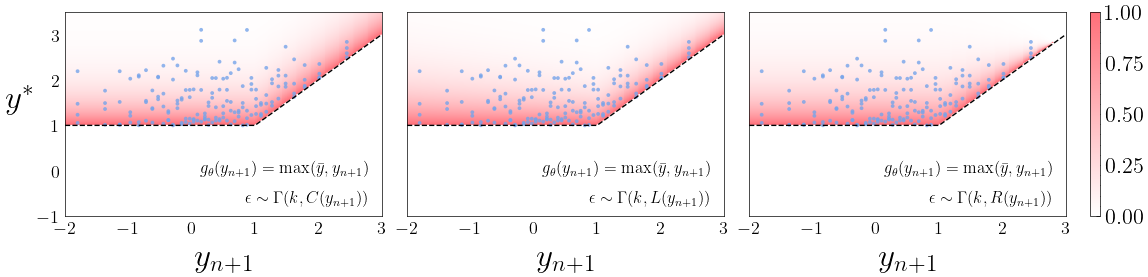

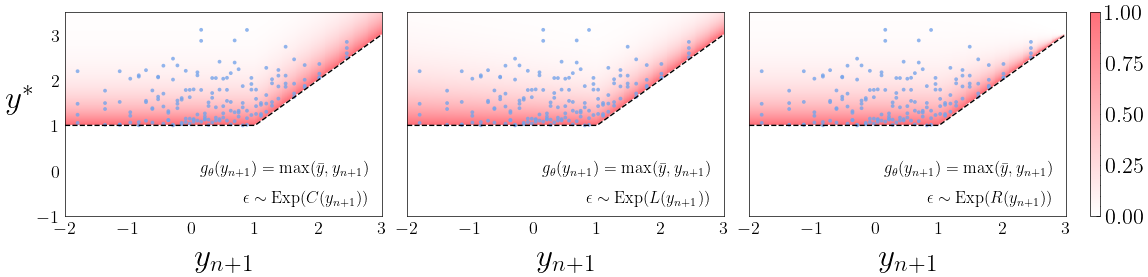

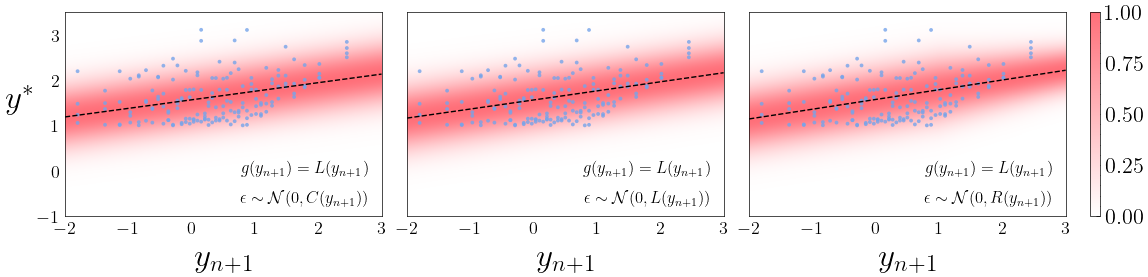

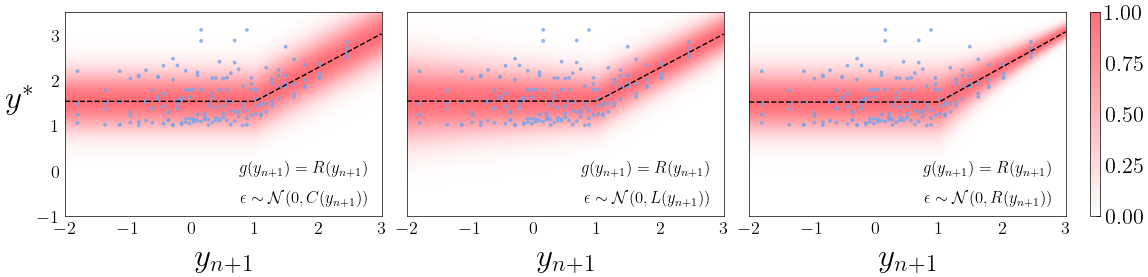

In [31]:
models_main_body = {
    "gamma_0_0": fit_gamma_0_0,
    "exp_2": fit_exp_2,
    "lr_1_0": fit_lr_1_0,
    "lr_2_2": fit_lr_2_2,
}

models_appendix_1 = {
    "gamma_0_0": fit_gamma_0_0,
    "gamma_0_1": fit_gamma_0_1,
    "gamma_0_2": fit_gamma_0_2,
}

models_appendix_2 = {
    "exp_0": fit_exp_0,
    "exp_1": fit_exp_1,
    "exp_2": fit_exp_2,
}

models_appendix_3 = {
    "lr_1_0": fit_lr_1_0,
    "lr_1_1": fit_lr_1_1,
    "lr_1_2": fit_lr_1_2,
}

models_appendix_4 = {
    "lr_2_0": fit_lr_2_0,
    "lr_2_1": fit_lr_2_1,
    "lr_2_2": fit_lr_2_2,
}

plot_trend_lines(models_main_body, "heatmaps-main-body", (16, 2.9))
plot_trend_lines(models_appendix_1, "heatmaps-appendix-1", (13, 2.9))
plot_trend_lines(models_appendix_2, "heatmaps-appendix-2", (13, 2.9))
plot_trend_lines(models_appendix_3, "heatmaps-appendix-3", (13, 2.9))
plot_trend_lines(models_appendix_4, "heatmaps-appendix-4", (13, 2.9))
